In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# RAG Based on Sensitive Data Protection using Faker


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/RAG_Based_on_Sensitive_Data_Protection_using_Faker.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Fretrieval-augmented-generation%2FRAG_Based_on_Sensitive_Data_Protection_using_Faker.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/RAG_Based_on_Sensitive_Data_Protection_using_Faker.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/RAG_Based_on_Sensitive_Data_Protection_using_Faker.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Omotayo Aina](https://github.com/ainaomotayo) | 

## Overview

This notebook shows how to use Cloud Data Loss Prevention (Cloud DLP) which is now a part of Sensitive Data Protection to anonymize PII data, replacing the found PII data with fake data generated by [Faker Library](https://github.com/joke2k/faker).

Ideally, only Crypto-based tokenization transformations techniques are reversible but to make replacement transformation reversible, we leverage on Firestore database to hold the original data and mapped it with the fake data generated. 

In this notebook, you will learn how to implement RAG with Sensitive Data Prevention to comply with your privacy requirements. We create text embeddings for publicly available site from [Vodafone Site](https://www.vodafone.com/about-vodafone/who-we-are/leadership/executive-committee/margherita-della-valle).

- [Gemini](https://ai.google.dev/models/gemini) is a family of generative AI models that lets developers generate content and solve problems. These models are designed and trained to handle both text and images as input.

- [LangChain](https://www.langchain.com/) is a framework designed to make integration of Large Language Models (LLM) like Gemini easier for applications.

- [Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma) is the open-source embedding database. Chroma makes it easy to build LLM apps by making knowledge, facts, and skills pluggable for LLMs.

- [Firestore](https://cloud.google.com/firestore/docs/overview) is a flexible, scalable database for mobile, web, and server development from Firebase and Google Cloud. 

- [Sensitive Data Protection](https://cloud.google.com/sensitive-data-protection/docs/sensitive-data-protection-overview) provides access to a powerful sensitive data inspection, classification, and de-identification platform.

- [Faker](https://github.com/joke2k/faker) is a Python package that generates fake data for you.

For more information, see the [Generative AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) on Vertex AI documentation.

## Getting Started

### Install Vertex AI SDK and other required packages

In [ ]:
%pip install --upgrade --user --quiet google-cloud-aiplatform google-cloud-firestore Faker google-cloud-dlp langchain-core langchain_google_vertexai chromadb

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}


import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Enable the Firestore and Generative Language API

In [ ]:
!gcloud services enable aiplatform.googleapis.com firestore.googleapis.com dlp.googleapis.com --project={PROJECT_ID}

### This create the default database with Native mode

In [ ]:
!gcloud firestore databases create --project=$PROJECT_ID --location=$LOCATION

## Architecture View
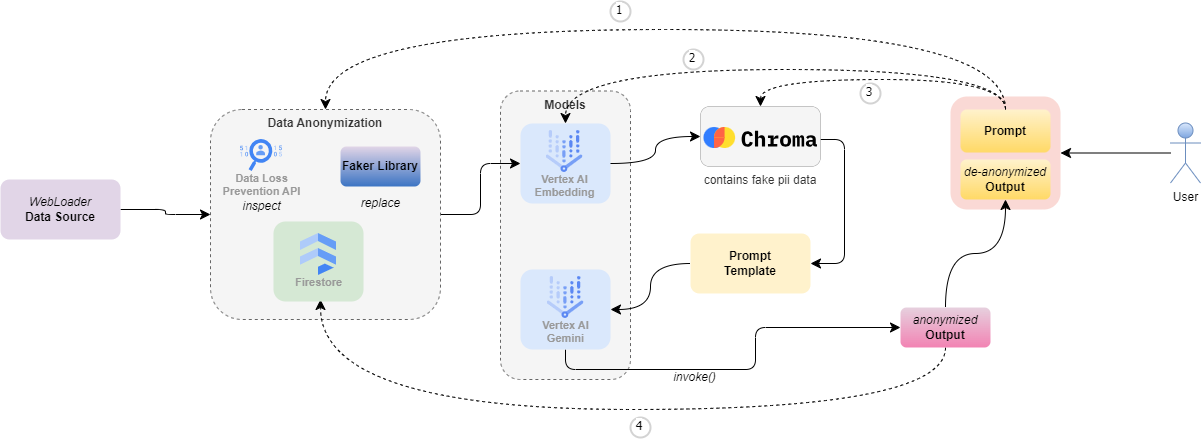

### Architecture Workflow:

1. User Prompt will be anonymized and the original sensitive data will be replaced by fake data generated by Faker Library, both data mapped and stored in Firestore.
    
2. Embedding is created on the anonymized data (Prompt)
  
3. Semantic Search is done using the anonymized data (Prompt) on the Vector Database
    
4. The output is de-anonymized by replacing the fake data with the mapped original data in the Firestore.

For better result, it is recommended that you use more efficient data extractor service for better data rendering and use more accuracy sensitive data detector such as Cloud DLP API

### Import libraries

In [ ]:
from faker import Faker
from google.cloud import dlp_v2, firestore
from google.cloud.dlp_v2.types import ContentItem, InspectConfig, InspectContentRequest
from langchain import PromptTemplate
from langchain.docstore.document import Document
from langchain.document_loaders import WebBaseLoader
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.vectorstores import Chroma

# Initialize Firestore client
db = firestore.Client()

# Initialize Faker
fake = Faker()

In [ ]:
# Create an instance of WebBaseLoader with the URL of the webpage to be loaded
loader = WebBaseLoader(
    "https://www.vodafone.com/about-vodafone/who-we-are/leadership/executive-committee/margherita-della-valle"
)

# Call the load method of the WebBaseLoader instance to fetch and parse the webpage
# The parsed webpage is stored in the 'documents' variable
documents = loader.load()

In [ ]:
# Print the contents of the 'documents' variable
# This variable is expected to contain the parsed webpage data
print(documents)

In [ ]:
# Extract the text from the website data document
text_content = documents[0].page_content

# The text content before the substrings "plc." is relevant for this tutorial.
# You can use Python's `split()` to select the required content.
final_text = text_content.split("plc.", 1)[0]

# Convert the text to LangChain's `Document` format
docs = [Document(page_content=final_text, metadata={"source": "local"})]

In [ ]:
# Print the contents of the 'documents' variable
# This variable is expected to contain the parsed webpage data
print(docs)

The code defines a class for reversible anonymization. 

The class uses the Google Cloud Data Loss Prevention (DLP) service to identify sensitive information in text, replaces the sensitive information with fake data generated by the Faker library, and stores the mapping from the original data to the fake data in Google Cloud Firestore. 

The class also provides a method for de-anonymizing text by replacing the fake data with the original data.

In [ ]:
# Import the Google API exceptions module
import google.api_core.exceptions as google_exceptions


# Define a class for reversible anonymization
class ReversibleAnonymizer:
    # Initialize the class with a Google Cloud project ID
    def __init__(self, project: str):
        # Create a client for the Google Cloud Data Loss Prevention (DLP) service
        self.dlp: dlp_v2.DlpServiceClient = dlp_v2.DlpServiceClient()
        # Create a Faker instance for generating fake data
        self.fake: Faker = Faker()
        # Create a client for the Google Cloud Firestore service
        self.db: firestore.Client = firestore.Client()
        # Store the Google Cloud project ID
        self.project: str = project

    # Define a method for anonymizing text
    def anonymize(self, text_to_deidentify: str) -> str | None:
        try:
            # Define the parent resource for the DLP API call
            parent: str = f"projects/{self.project}/locations/global"
            # Define the types of sensitive information to look for
            info_types = [
                {"name": "PERSON_NAME"},
                {"name": "PHONE_NUMBER"},
                {"name": "FIRST_NAME"},
                {"name": "LAST_NAME"},
            ]
            # Define the configuration for the DLP inspection
            inspect_config = InspectConfig(info_types=info_types, include_quote=True)
            # Define the item to inspect
            item = ContentItem(value=text_to_deidentify)
            # Call the DLP API to inspect the text
            response = self.dlp.inspect_content(
                request=InspectContentRequest(
                    parent=parent,
                    inspect_config=inspect_config,
                    item=item,
                )
            )

            # For each finding, replace the sensitive data with fake data
            for finding in response.result.findings:
                # Check if the original data is already mapped to fake data
                docs = (
                    self.db.collection("mappings")
                    .where("original_data", "==", finding.quote)
                    .stream()
                )
                docs = list(docs)
                if docs:
                    # If the original data is already mapped, use the existing fake data
                    fake_data: str = docs[0].id
                else:
                    # If the original data is not already mapped, generate new fake data
                    if finding.info_type.name == "PERSON_NAME":
                        fake_data: str = self.fake.name()
                    elif finding.info_type.name == "FIRST_NAME":
                        fake_data: str = self.fake.first_name()
                    elif finding.info_type.name == "LAST_NAME":
                        fake_data: str = self.fake.last_name()
                    else:
                        fake_data: str = self.fake.phone_number()
                    # Store the mapping from the original data to the fake data
                    doc_ref: firestore.DocumentReference = self.db.collection(
                        "mappings"
                    ).document(fake_data)
                    doc_ref.set({"original_data": finding.quote})

                # Replace the original data with the fake data in the text
                text_to_deidentify = text_to_deidentify.replace(
                    finding.quote, fake_data
                )

            # Return the anonymized text
            return text_to_deidentify

        except google_exceptions.GoogleAPICallError as e:
            # If an error occurs, print the error and return None
            print(f"An error occurred: {e}")
            return None

    # Define a method for de-anonymizing text
    def deanonymize(self, text: str) -> str | None:
        try:
            # For each mapping from original data to fake data, replace the fake data with the original data in the text
            docs = self.db.collection("mappings").stream()
            for doc in docs:
                text = text.replace(doc.id, doc.to_dict()["original_data"])
            # Return the de-anonymized text
            return text
        except google_exceptions.GoogleAPICallError as e:
            # If an error occurs, print the error and return None
            print(f"An error occurred: {e}")
            return None

Create an instance of the ReversibleAnonymizer class, passing the Google Cloud project ID as an argument.

In [ ]:
# This instance, 'anonymizer', can now be used to call the anonymize and deanonymize methods defined in the ReversibleAnonymizer class.
anonymizer = ReversibleAnonymizer(PROJECT_ID)

In [ ]:
# This line of code is using a list comprehension to create a new list, 'anonymized_docs'.
# It iterates over each 'doc' in the 'docs' list, and for each 'doc', it calls the 'anonymize' method of the 'anonymizer' instance.
# The 'anonymize' method takes the 'page_content' of the 'doc' as an argument and returns the anonymized text.
# The result is a new list where each element is the anonymized version of the corresponding 'doc' in the 'docs' list.

anonymized_docs = [anonymizer.anonymize(doc.page_content) for doc in docs]

In [ ]:
# 'anonymized_docs' is a list that contains the anonymized versions of the documents in the 'docs' list.
# Each document in 'docs' has been processed by the 'anonymize' method of the 'anonymizer' instance, which replaces sensitive information with fake data.
# The 'anonymize' method uses the Google Cloud Data Loss Prevention (DLP) service to identify sensitive information and the Faker library to generate the fake data.

anonymized_docs

In [ ]:
# Convert the anonymized doc text to LangChain's `Document` format
anonymized_docs = [
    Document(page_content=doc, metadata={"source": "local"}) for doc in anonymized_docs
]

In [ ]:
anonymized_docs

In [ ]:
from langchain_google_vertexai import VertexAIEmbeddings

gemini_embeddings = VertexAIEmbeddings(model_name="textembedding-gecko@003")

In [ ]:
# Save to disk
vectorstore = Chroma.from_documents(
    documents=anonymized_docs,  # Data
    embedding=gemini_embeddings,  # Embedding model
    persist_directory="./chroma_db4",  # Directory to save data
)

In [ ]:
# The 'get' method of the 'vectorstore' instance is being called here.
# This method is typically used to retrieve a vector representation of a given input from the vector store.
# The exact behavior depends on the implementation of the 'get' method in the 'vectorstore' class.

vectorstore.get()

In [ ]:
# Load from disk
vectorstore_disk = Chroma(
    persist_directory="./chroma_db4",  # Directory of db
    embedding_function=gemini_embeddings,  # Embedding model
)
# Get the Retriever interface for the store to use later.
# When an unstructured query is given to a retriever it will return documents.
# Read more about retrievers in the following link.
# https://python.langchain.com/docs/modules/data_connection/retrievers/
#
# Since only 1 document is stored in the Chroma vector store, search_kwargs `k`
# is set to 1 to decrease the `k` value of chroma's similarity search from 4 to
# 1. If you don't pass this value, you will get a warning.
retriever = vectorstore_disk.as_retriever(search_kwargs={"k": 1})

In [ ]:
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model_name="gemini-1.0-pro", temperature=0.7)

In [ ]:
# Prompt template to query Gemini
llm_prompt_template = """You are an assistant for question-answering tasks.
Use the following context to answer the question.
If you don't know the answer, just say that you don't know.
Use five sentences maximum and keep the answer concise.\n
Question: {question} \nContext: {context} \nAnswer:"""

llm_prompt = PromptTemplate.from_template(llm_prompt_template)

print(llm_prompt)

In [ ]:
# Combine data from documents to readable string format.


def format_docs(anonymized_docs):
    return "\n\n".join(doc.page_content for doc in anonymized_docs)


# Create stuff documents chain using LCEL.
#
# This is called a chain because you are chaining together different elements
# with the LLM. In the following example, to create the stuff chain, you will
# combine the relevant context from the website data matching the question, the
# LLM model, and the output parser together like a chain using LCEL.
#
# The chain implements the following pipeline:
# 1. Extract the website data relevant to the question from the Chroma
#    vector store and save it to the variable `context`.
# 2. `RunnablePassthrough` option to provide `question` when invoking
#    the chain.
# 3. The `context` and `question` are then passed to the prompt where they
#    are populated in the respective variables.
# 4. This prompt is then passed to the LLM (`gemini-pro`).
# 5. Output from the LLM is passed through an output parser
#    to structure the model's response.
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | llm_prompt
    | llm
    | StrOutputParser()
)

In [ ]:
# This method is typically used to ask a question to the RAG (Retrieval-Augmented Generation) model containing Embeddings created with anonymized PII data.
# The RAG model is a type of question-answering model that retrieves relevant documents from a corpus and then generates an answer based on those documents.
# The result of this method call will be the answer to the question as generated by the RAG model before De-anonymization - This is not what we want.

rag_chain.invoke("Who is the CEO of Vodafone Group?")

In [ ]:
# Before execution of this 'invoke' method an anonymize method will be called on anonymizer instance to efficiently use the RAG
# After which the result of this method call will be the answer to the question as generated by the RAG model
# Then it will go through de-anonymization by replacing the fake data with orignal data - This is what we want to achieve.

anonymized_text = anonymizer.anonymize("Who is the CEO of Vodafone Group?")

# Invoke the rag_chain with anonymized text
response = rag_chain.invoke(anonymized_text)

# Deanonymize the response
anonymizer.deanonymize(response)